# Clasificación de textos: Naive Bayes 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random

from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from nltk.corpus import movie_reviews

/home/ddellera/p3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/ddellera/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /home/ddellera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
movie_reviews.categories()

['neg', 'pos']

In [3]:
neg_review_fileids = movie_reviews.fileids('neg')
neg_review_fileids[:10]

['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt',
 'neg/cv005_29357.txt',
 'neg/cv006_17022.txt',
 'neg/cv007_4992.txt',
 'neg/cv008_29326.txt',
 'neg/cv009_29417.txt']

In [4]:
print(movie_reviews.raw(neg_review_fileids[2]))

it is movies like these that make a jaded movie viewer thankful for the invention of the timex indiglo watch . 
based on the late 1960's television show by the same name , the mod squad tells the tale of three reformed criminals under the employ of the police to go undercover . 
however , things go wrong as evidence gets stolen and they are immediately under suspicion . 
of course , the ads make it seem like so much more . 
quick cuts , cool music , claire dane's nice hair and cute outfits , car chases , stuff blowing up , and the like . 
sounds like a cool movie , does it not ? 
after the first fifteen minutes , it quickly becomes apparent that it is not . 
the mod squad is certainly a slick looking production , complete with nice hair and costumes , but that simply isn't enough . 
the film is best described as a cross between an hour-long cop show and a music video , both stretched out into the span of an hour and a half . 
and with it comes every single clich ? . 
it doesn't really 

In [6]:
documents = []
 
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append((movie_reviews.raw(fileid), category))

df = pd.DataFrame(documents, columns=['review', 'tag'])


In [7]:
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
df.head()

,review,tag
0,arnold schwarzenegger has been an icon for act...,neg
1,good films are hard to find these days . \ngre...,pos
2,quaid stars as a man who has taken up the prof...,pos
3,we could paraphrase michelle pfieffer's charac...,neg
4,kolya is one of the richest films i've seen in...,pos


In [8]:
df.tag.value_counts()

neg    1000
pos    1000
Name: tag, dtype: int64

In [9]:
# separamos entre train y test sets
X = df.review
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

In [51]:
X_train_text.tolist()[:2]

['wolfgang petersen\'s latest , the perfect storm , is like a pineapple . \nit only tastes good after arduous peeling and digging - if you try to eat the fruit , spikes and all , it\'s going to hurt ? quite a bit . \nok , maybe that was a confusing analogy , so here\'s my main complaint about the latest man battles nature flick : there isn\'t really much of a story to tell . \nbasically , a massachusetts fishing crew goes out to sea on a small boat , called the andrea gail , and gets stuck in the middle of " the storm of the century . " \nhow much time does it take for petersen to tell this story ? \nnot nearly enough . \nso he spends the majority of the film developing pointless side stories which all eventually become superfluous . \naudiences want to see the storm , they want to see a fight for survival but what they get is a lot of cliched , maudlin drivel . \nthe last quarter of the perfect storm is utterly perfect in every aspect , but just try lasting the first three-quarters . 

In [16]:
# Limpieza del texto
def clean_text(text):
  # En este caso particular no hace falta limpiar los textos
  return text.strip()

In [17]:
def tokenizer(text):
    #return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return word_tokenize(text)

In [18]:
tokenizer(clean_text(X_train_text.iloc[1]))[:10]

['i',
 'have',
 'to',
 'admit',
 'that',
 'i',
 'disliked',
 'this',
 'film',
 'initially']

## extraccion de Features


In [19]:
?CountVectorizer

In [20]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words="english")
X_train = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario
X_train

<1600x11496 sparse matrix of type '<class 'numpy.int64'>'
	with 358789 stored elements in Compressed Sparse Row format>

In [52]:
?count_vect.get_feature_names

In [21]:
count_vect.get_feature_names()[:20]

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "'60s",
 "'70s",
 "'80s",
 "'90s",
 "'97",
 "'cause",
 "'d",
 "'em",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'the",
 "'ve"]

# Naive Bayes

In [22]:
clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
scores_cv_nb = cross_val_score(clf,X_train, y_train,cv = 10, scoring='f1_macro')
scores_cv_nb


array([0.78746679, 0.83092638, 0.79971835, 0.84962406, 0.83119065,
       0.75601173, 0.81176471, 0.80618186, 0.77485929, 0.8125    ])

In [23]:
print("f-score=",round(scores_cv_nb.mean(),4)," ( sd =",round(scores_cv_nb.std(),4),")")

f-score= 0.806  ( sd = 0.0266 )


### Dummy

In [25]:
clf_dummy = DummyClassifier()
scores_dummy_cv = cross_val_score(clf_dummy,X_train, y_train,cv = 10, scoring='f1_macro')
print("f-score=",round(scores_dummy_cv.mean(),4),"+/-",round(scores_dummy_cv.std(),4))

f-score= 0.5025 +/- 0.0423


/home/ddellera/p3/lib/python3.5/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T
/home/ddellera/p3/lib/python3.5/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T
/home/ddellera/p3/lib/python3.5/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T
/home/ddellera/p3/lib/python3.5/site-packages/sklearn/d

## N-gramas

In [26]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words="english",ngram_range=(1,2))
X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
print("numero de features=",X_train_ngrams.shape[1])

scores_cv_ngrams = cross_val_score(clf,X_train_ngrams, y_train,cv = 10, scoring='f1_macro')
print("f-score=",round(scores_cv_ngrams.mean(),4)," ( sd =",round(scores_cv_ngrams.std(),4),")")

numero de features= 26189
f-score= 0.8023  ( sd = 0.028 )


In [54]:
count_vect.get_feature_names()[1000:1005]

['beating', 'beats', 'beatty', 'beau', 'beautiful']

### Pruebo otros parametros

In [28]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=30, stop_words="english",ngram_range=(1,2))
X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
print("numero de features=",X_train_ngrams.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_v2 = cross_val_score(clf,X_train_ngrams, y_train,cv = 10, scoring='f1_macro')
print("f-score=",round(scores_cv_ngrams_v2.mean(),4)," ( sd =",round(scores_cv_ngrams_v2.std(),4),")")

numero de features= 3655
f-score= 0.8036  ( sd = 0.0159 )


## Selecciono el mejor modelo

In [29]:
pd.Series({'NB (mindf=5)':round(scores_cv_nb.mean(),3),'NB with ngrams (mindf=5)':round(scores_cv_ngrams.mean(),3),'NB with ngrams (mindf=30)':round(scores_cv_ngrams_v2.mean(),3)})

NB (mindf=5)                 0.806
NB with ngrams (mindf=30)    0.804
NB with ngrams (mindf=5)     0.802
dtype: float64

In [30]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words="english",ngram_range=(1,1))
X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario
print("numero de features=",X_train_ngrams.shape[1])
# entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)
# predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)
scores_ngrams = pd.Series(precision_recall_fscore_support(y_test, y_pred,average="macro")[:3],index=["precision","recall","fscore"])
print("matriz de confusión\n",confusion_matrix(y_test, y_pred))

print("\nNgrams\n")
print(scores_ngrams)

numero de features= 11496
matriz de confusión
 [[170  30]
 [ 44 156]]

Ngrams

precision    0.816551
recall       0.815000
fscore       0.814773
dtype: float64


##  Normalización

In [31]:
# Stemizacion: lleva una palabra a su raíz (la cual puede no ser una palabra) 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
stemmer.stem("explanation")

'explan'

In [32]:
[(w,stemmer.stem(w)) for w in word_tokenize(clean_text(X_train_text.iloc[0])) if w.isalpha()]

[('wolfgang', 'wolfgang'),
 ('petersen', 'petersen'),
 ('latest', 'latest'),
 ('the', 'the'),
 ('perfect', 'perfect'),
 ('storm', 'storm'),
 ('is', 'is'),
 ('like', 'like'),
 ('a', 'a'),
 ('pineapple', 'pineappl'),
 ('it', 'it'),
 ('only', 'onli'),
 ('tastes', 'tast'),
 ('good', 'good'),
 ('after', 'after'),
 ('arduous', 'arduous'),
 ('peeling', 'peel'),
 ('and', 'and'),
 ('digging', 'dig'),
 ('if', 'if'),
 ('you', 'you'),
 ('try', 'tri'),
 ('to', 'to'),
 ('eat', 'eat'),
 ('the', 'the'),
 ('fruit', 'fruit'),
 ('spikes', 'spike'),
 ('and', 'and'),
 ('all', 'all'),
 ('it', 'it'),
 ('going', 'go'),
 ('to', 'to'),
 ('hurt', 'hurt'),
 ('quite', 'quit'),
 ('a', 'a'),
 ('bit', 'bit'),
 ('ok', 'ok'),
 ('maybe', 'mayb'),
 ('that', 'that'),
 ('was', 'was'),
 ('a', 'a'),
 ('confusing', 'confus'),
 ('analogy', 'analog'),
 ('so', 'so'),
 ('here', 'here'),
 ('my', 'my'),
 ('main', 'main'),
 ('complaint', 'complaint'),
 ('about', 'about'),
 ('the', 'the'),
 ('latest', 'latest'),
 ('man', 'man'),
 ('b

#### notar que "empathy" y "empathize" no van a la misma raiz!

In [33]:
print(stemmer.stem("empathy"))
print(stemmer.stem("empathize"))

empathi
empath


In [34]:
# Lematizacion: lleva una palabra a su forma canónica
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/ddellera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ddellera/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [35]:
# para lemmatizar es necesario dar la categoria gramatical(part-of-speech)
# los POS validos son ("a","v","n","r")(adjetivo,verbo,sustantivo,advervio)
wnl.lemmatize(word="was",pos="v")

'be'

In [36]:
postags = pos_tag(word_tokenize(clean_text(X_train_text.iloc[1])))
postags

[('i', 'NNS'),
 ('have', 'VBP'),
 ('to', 'TO'),
 ('admit', 'VB'),
 ('that', 'IN'),
 ('i', 'NN'),
 ('disliked', 'VBD'),
 ('this', 'DT'),
 ('film', 'NN'),
 ('initially', 'RB'),
 ('.', '.'),
 ('it', 'PRP'),
 ('certianly', 'RB'),
 ('is', 'VBZ'),
 ("n't", 'RB'),
 ('for', 'IN'),
 ('every', 'DT'),
 ('taste', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('sheer', 'JJ'),
 ('torture', 'NN'),
 ('to', 'TO'),
 ('sit', 'VB'),
 ('through', 'IN'),
 ('if', 'IN'),
 ('you', 'PRP'),
 ("'re", 'VBP'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('restless', 'JJ'),
 ('mood', 'NN'),
 ('.', '.'),
 ('that', 'WDT'),
 ('said', 'VBD'),
 (',', ','),
 ('if', 'IN'),
 ('you', 'PRP'),
 ('are', 'VBP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('right', 'JJ'),
 ('mood', 'NN'),
 (',', ','),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('absolutely', 'RB'),
 ('incredible', 'JJ'),
 ('.', '.'),
 ('this', 'DT'),
 ('was', 'VBD'),
 ('my', 'PRP$'),
 ('second', 'JJ'),
 ('favorite', 'JJ'),
 ('movie', 'NN'),
 ('of', 'IN'),
 ('1998', 'CD'),
 (

In [39]:
def word_pos_to_lemma(word,pos,wnl):
    if pos.startswith('J'):
        return wnl.lemmatize(word,wordnet.ADJ) # adjetivo
    elif pos.startswith('V'):
        return wnl.lemmatize(word,wordnet.VERB) # verbo
    elif pos.startswith('N'):
        return wnl.lemmatize(word,wordnet.NOUN)# sustantivo
    elif pos.startswith('R'):
        return wnl.lemmatize(word,wordnet.ADV) # adverbio
    else:
        return wnl.lemmatize(word)

In [40]:
[(w,word_pos_to_lemma(w,pos,wnl) ) for w,pos in postags if w.isalpha()][:25]

[('i', 'i'),
 ('have', 'have'),
 ('to', 'to'),
 ('admit', 'admit'),
 ('that', 'that'),
 ('i', 'i'),
 ('disliked', 'dislike'),
 ('this', 'this'),
 ('film', 'film'),
 ('initially', 'initially'),
 ('it', 'it'),
 ('certianly', 'certianly'),
 ('is', 'be'),
 ('for', 'for'),
 ('every', 'every'),
 ('taste', 'taste'),
 ('and', 'and'),
 ('it', 'it'),
 ('sheer', 'sheer'),
 ('torture', 'torture'),
 ('to', 'to'),
 ('sit', 'sit'),
 ('through', 'through'),
 ('if', 'if'),
 ('you', 'you')]

## Zipf's Law

In [41]:
# Serie con todas las palabras del corpus
words_series = pd.Series([word for rev in df.review for word in word_tokenize(rev) if word.isalpha()])  

In [42]:
# Frecuencia de cada palabra en el corpus
word_freq = words_series.value_counts()
word_freq

the              76276
a                37995
and              35404
of               33972
to               31772
                 ...  
kurgan               1
retrieves            1
macalaester          1
efficent             1
electrocuting        1
Length: 38107, dtype: int64

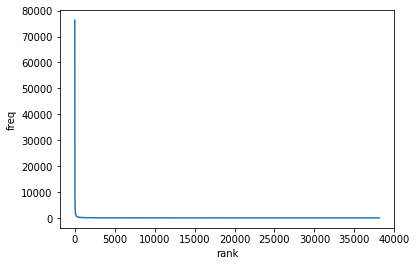

In [43]:
# plot de frecuencia vs ranking (la palabra mas frecuente tiene rank=1, la segunda tiene rank=2, etc..)
plt.plot(range(len(word_freq)),word_freq)
plt.xlabel('rank');plt.ylabel('freq');


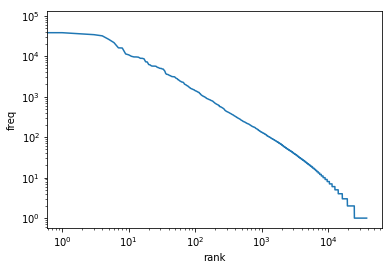

In [44]:
# ahora en eje logaritmico
plt.plot(range(len(word_freq)),word_freq)
plt.xlabel('rank');plt.ylabel('freq')
plt.xscale('log'); plt.yscale('log');

In [45]:
# palabras con 1 sola occurrencia
sum(word_freq==1)/len(word_freq)

0.3481512582990002

# Ejercicio 1
## Armar un clasificador que identifique si una review de IMDB es positivo (1) o negativo (0)
## comparar varios modelos y seleccionar el que produzca un mejor 10-fold CV o un mejor performance en el dev set
## predecir en el test set y calcular la matriz de confusion, precision, recall y F-score

In [46]:
import tensorflow_datasets as tfds


In [47]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

df_train = pd.DataFrame(list(tfds.as_numpy(train_data)),columns=['texto','clase'])
df_dev = pd.DataFrame(list(tfds.as_numpy(validation_data)),columns=['texto','clase'])
df_test = pd.DataFrame(list(tfds.as_numpy(test_data)),columns=['texto','clase'])

In [48]:
df_train.sample(5)

,texto,clase
14772,"b""I've read some of the other comments and I d...",0
3191,"b""First off, I had my doubts just looking at t...",0
8487,"b""Yet another film about a tortured self-cente...",0
13267,b'Lord Alan Cunningham(Antonio De Teff\xc3\xa8...,0
2680,b'I\'d been following this films progress for ...,0


In [49]:
def b2str(b):
  return b.decode('utf8')

df_dev['texto'] = df_dev['texto'].apply(b2str)
df_train['texto'] = df_train['texto'].apply(b2str)
df_test['texto'] = df_test['texto'].apply(b2str)

In [50]:
df_train.sample(5)

,texto,clase
3108,Robert Wuhl is teaching a class of film studen...,1
2752,"The name ""cult movie"" is often given to films ...",0
8400,** HERE BE SPOILERS **<br /><br />The governme...,0
9439,First off I want to say that this film is wort...,0
7371,Not even Goebbels could have pulled off a prop...,0
